<a href="https://colab.research.google.com/github/KrishPraba/Pump-it-Up-Data-Mining-the-Water-Table/blob/main/Pump_it_Up_Preprocessing_%26_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Importing Necessary Libraries**

In [64]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

#**Loading Data**

In [177]:
features_df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Train_set_values.csv")    # train set data

labels_df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Train_set_labels.csv")      # train set labels data

test_df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Test_set_values.csv")         # test set data

In [178]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [179]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [180]:
train_labels = labels_df.drop(columns=['id'])
train_set = features_df.drop(columns=['id'])

In [181]:
features_df['from'] = 'train'
test_df['from'] = 'test'
joined_df = features_df.append(test_df)

In [182]:
print(joined_df.shape)

(74250, 41)


#**Pre-processing**

**Plot mutual information scores**

---



In [163]:
def make_mi_scores(X, y):
    X_mi = X.copy()
    y_mi = y.copy()
    for colname in X_mi.select_dtypes(["object", "category"]):
        X_mi[colname], _ = X_mi[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X_mi.dtypes]
    mi_scores = mutual_info_classif(X_mi, y_mi.values.ravel(), discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

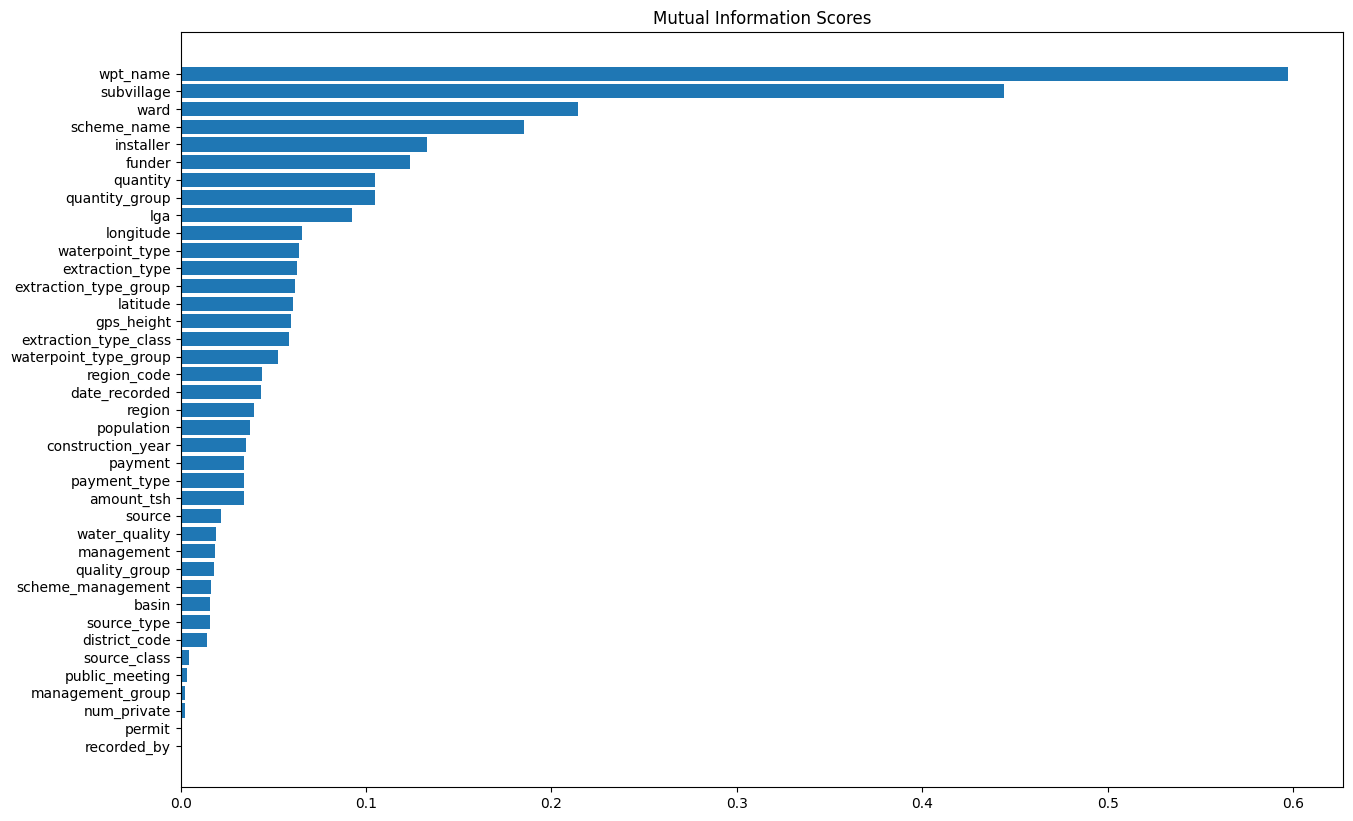

In [164]:
mi_scores = make_mi_scores(train_set, train_labels)
plt.figure(dpi=100, figsize=(15, 10))
plot_mi_scores(mi_scores.head(40))

In [183]:
df_categorical = train_set.select_dtypes(include='object')
object_cols = df_categorical.columns.tolist()     #String columns in the dataset

df_numerical = train_set.select_dtypes(exclude='object')
numeric_cols = df_numerical.columns.tolist()      #Numeric columns in the dataset

print(object_cols)
print(numeric_cols)

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']


**Handling Missing and Outlier Values**

---



The **installer** columns contain value 0 as observed during EDA This are outliers and do not match the relevant column which contains installer names.These are converted to "unknown"

The **longitude and population** outliers are converted to mean values.

The **construction year** missing values were converted to the median value

In [184]:
joined_df['installer'].replace(to_replace = '0', value ='Unknown' , inplace=True)
joined_df['longitude'].replace(to_replace = 0, value =None , inplace=True)
joined_df['population'].replace(to_replace = 0 , value = None, inplace=True)
joined_df['construction_year'].replace(to_replace = 0, value = None, inplace=True)

In [185]:
replace_cols = ['longitude', 'population']

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
for cols in replace_cols:
  joined_df[cols] = imputer.fit_transform(joined_df[cols].values.reshape(-1,1))[:,0]

imputer_d = SimpleImputer(missing_values=np.nan, strategy='median')
joined_df['construction_year'] = imputer_d.fit_transform(joined_df['construction_year'].values.reshape(-1,1))[:,0]

The values of the other columns with missing values are converted to a common value unknown. No numeric columns had missing values.

In [186]:
joined_df['funder'].fillna(value='Unknown', inplace=True)
joined_df['installer'].fillna(value='Unknown' , inplace=True)
joined_df['subvillage'].fillna(value='Unknown' , inplace=True)
joined_df['public_meeting'].fillna(value='Unknown' , inplace=True)
joined_df['scheme_management'].fillna(value='Unknown' , inplace=True)
joined_df['scheme_name'].fillna(value='Unknown' , inplace=True)
joined_df['permit'].fillna(value='Unknown' , inplace=True)

**Encoding features to be used in classifiers**

---



In [187]:
final_df = joined_df.copy()

In [170]:
mask = final_df.applymap(type) != bool
d = {True: 'TRUE', False: 'FALSE'}

final_df = final_df.where(mask, final_df.replace(d))

**Label Encoding on the features**

In [171]:
from sklearn.preprocessing import OrdinalEncoder

for item in object_cols:
  ordinalencoder = OrdinalEncoder()
  final_df[item] = ordinalencoder.fit_transform(final_df[[item]])

final_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,from
0,69572,6000.0,54.0,1548.0,1390,1705.0,34.938093,-9.856322,45683.0,0,1.0,13116.0,3.0,11,5,51.0,1429.0,109.0,1.0,0.0,8.0,2388.0,0.0,1999.0,3.0,1.0,0.0,7.0,4.0,2.0,0.0,6.0,2.0,1.0,1.0,8.0,6.0,0.0,1.0,1.0,train
1,8776,0.0,322.0,522.0,1399,609.0,34.698766,-2.147466,45426.0,0,4.0,17596.0,9.0,20,2,103.0,1581.0,280.0,2.0,0.0,2.0,2674.0,1.0,2010.0,3.0,1.0,0.0,11.0,4.0,0.0,2.0,6.0,2.0,2.0,2.0,5.0,3.0,1.0,1.0,1.0,train
2,34310,25.0,313.0,924.0,686,2295.0,37.460664,-3.821329,17767.0,0,5.0,10096.0,8.0,21,4,108.0,1629.0,250.0,1.0,0.0,8.0,2261.0,1.0,2009.0,3.0,1.0,0.0,7.0,4.0,4.0,5.0,6.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,train
3,67743,0.0,285.0,1961.0,263,2077.0,38.486161,-11.155298,45537.0,0,7.0,9998.0,12.0,90,63,87.0,1576.0,58.0,1.0,0.0,8.0,2674.0,1.0,1986.0,14.0,10.0,5.0,7.0,4.0,0.0,2.0,6.0,2.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,train
4,19728,0.0,111.0,20.0,0,132.0,31.130847,-1.825359,43411.0,0,4.0,8583.0,4.0,18,1,26.0,1692.0,58.0,1.0,0.0,7.0,2674.0,1.0,1986.0,3.0,1.0,0.0,1.0,1.0,0.0,2.0,6.0,2.0,3.0,3.0,5.0,3.0,1.0,1.0,1.0,train


**One hot encoding on the features**

In [26]:
final_df = pd.get_dummies(final_df)

Label encoding proved to be effective and efficient considering the large number of features present

**Min-Max Normalising the numerical columns**

---



In [172]:
from sklearn import preprocessing
import numpy as np

min_max_scaler = preprocessing.MinMaxScaler()
final_df[numeric_cols] = min_max_scaler.fit_transform(final_df[numeric_cols])

final_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,from
0,69572,0.017143,54.0,1548.0,0.516219,1705.0,0.496455,0.153923,45683.0,0.0,1.0,13116.0,3.0,0.102041,0.0625,51.0,1429.0,0.003541,1.0,0.0,8.0,2388.0,0.0,0.735849,3.0,1.0,0.0,7.0,4.0,2.0,0.0,6.0,2.0,1.0,1.0,8.0,6.0,0.0,1.0,1.0,train
1,8776,0.000000,322.0,522.0,0.519358,609.0,0.474167,0.815659,45426.0,0.0,4.0,17596.0,9.0,0.193878,0.0250,103.0,1581.0,0.009148,2.0,0.0,2.0,2674.0,1.0,0.943396,3.0,1.0,0.0,11.0,4.0,0.0,2.0,6.0,2.0,2.0,2.0,5.0,3.0,1.0,1.0,1.0,train
2,34310,0.000071,313.0,924.0,0.270666,2295.0,0.731374,0.671973,17767.0,0.0,5.0,10096.0,8.0,0.204082,0.0500,108.0,1629.0,0.008164,1.0,0.0,8.0,2261.0,1.0,0.924528,3.0,1.0,0.0,7.0,4.0,4.0,5.0,6.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,train
3,67743,0.000000,285.0,1961.0,0.123125,2077.0,0.826875,0.042418,45537.0,0.0,7.0,9998.0,12.0,0.908163,0.7875,87.0,1576.0,0.001869,1.0,0.0,8.0,2674.0,1.0,0.490566,14.0,10.0,5.0,7.0,4.0,0.0,2.0,6.0,2.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,train
4,19728,0.000000,111.0,20.0,0.031392,132.0,0.141899,0.843309,43411.0,0.0,4.0,8583.0,4.0,0.173469,0.0125,26.0,1692.0,0.001869,1.0,0.0,7.0,2674.0,1.0,0.490566,3.0,1.0,0.0,1.0,1.0,0.0,2.0,6.0,2.0,3.0,3.0,5.0,3.0,1.0,1.0,1.0,train


#**Feature Engineering**

In [188]:
final_df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'from'],
      dtype='object')

**Id** was dropped. The duplicate columns **payment , quantity** were dropped. Simultaneously grouped category fields **scheme_management , source_class , source_type quality_group , extraction_type_class , extraction_type_group , waterpoint_type_group , management_group** were dropped. The field **recorded_by** containing only one value is dropped. And finally **num_private** which had no relavance to dataset was also removed

In [ ]:
'recorded_by', 'num_private', 'wpt_name', 'extraction_type_group', 'extraction_type', 'payment_type', 'water_quality', 'scheme_management',
         'district_code', 'region','region_code', 'subvillage', 'ward', 'waterpoint_type_group', 'quantity_group', 'installer', 'scheme_name'

'recorded_by','scheme_management','source_class','source_type','quality_group',
                                        'extraction_type_class','extraction_type_group','waterpoint_type_group',
                                        'management_group','payment','quantity','num_private'

In [189]:
final_df = final_df.drop(columns=['recorded_by','scheme_management','source_class','source_type','quality_group','extraction_type_class','extraction_type_group',
                                  'waterpoint_type_group', 'management_group','payment','quantity','num_private'])

In [190]:
print(final_df.shape)

(74250, 29)


In [191]:
final_df.to_csv('/content/drive/MyDrive/Machine Learning/preprocessed_unencoded_data.csv')